# Housing Prices: Advanced Regression


In [1]:
import random
import os
import csv
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

%matplotlib inline

In [49]:
def encode_features(df_train, df_test):
    '''
    Takes columns whose values are strings (objects)
    and categorizes them into discrete numbers.
    This makes it feasible to use regression
    '''
    features = list(df_train.select_dtypes(include=['object']).columns)
    df_combined = pd.concat([df_train[features], df_test[features]])

    for feature in features:
        unique_categories = list(df_combined[feature].unique())
        map_dict = {}
        for idx, category in enumerate(unique_categories):
            map_dict[category] = idx + 1
        df_train[feature] = df_train[feature].map(map_dict)
        df_test[feature] = df_test[feature].map(map_dict)
    
    return df_train, df_test


def cleanup(df):
    '''
    Cleans data
        1. Creates new features:
            - total bathrooms = full + half bathrooms
            - total porch area = closed + open porch area
        2. Drops unwanted features
        3. Fills missing values with the mode
        4. Performs feature scaling
    '''
    to_drop = ['MiscFeature', 'MiscVal', 'GarageArea', 'GarageYrBlt', 'Street', 'Alley',
              'LotShape', 'LandContour', 'LandSlope', 'RoofMatl', 'Exterior2nd', 'MasVnrType',
              'MasVnrArea', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
              'BsmtFinSF1', 'BsmtFinSF1', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'Electrical',
              'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
              'HalfBath', 'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'FireplaceQu',
              'GarageType', 'GarageFinish', 'GarageQual', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF',
              'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolQC', 'MoSold']
    df['Bathrooms'] = df['FullBath'] + df['HalfBath']
    df['PorchSF'] = df['EnclosedPorch'] + df['OpenPorchSF']
    df = df.drop(to_drop, axis=1)
    for column in df.columns:
        x = df[column].dropna().value_counts().index[0]
        df = df.fillna(x)
        if df[column].dtype != 'object' and column != 'SalePrice':
            m = df[column].min()
            M = df[column].max()
            Range = M - m
            df[column] = (df[column] - m) / Range
    return df

In [113]:
data_dir = 'data'

train_dataset = pd.read_csv(os.path.join(data_dir, 'train.csv'))
test_dataset = pd.read_csv(os.path.join(data_dir, 'test.csv'))

train_dataset = cleanup(train_dataset)
test_dataset = cleanup(test_dataset)
train_dataset, test_dataset = encode_features(train_dataset, test_dataset)

In [51]:
# Shuffle data
train_dataset = train_dataset.sample(frac=1)
# Split into training, validation, and testing datasets
train, valid, test = np.split(train_dataset,
                        [int(.6 * len(train_dataset)), int(.8 * len(train_dataset))])

# Convert into numpy arrays
x_train = train.drop(['SalePrice', 'Id'], axis=1).as_matrix().astype(np.float32)
y_train = train['SalePrice'].as_matrix().astype(np.float32).reshape((np.shape(x_train)[0], 1))
x_test = test.drop(['SalePrice', 'Id'], axis=1).as_matrix().astype(np.float32)
y_test = test['SalePrice'].as_matrix().astype(np.float32).reshape((np.shape(x_test)[0], 1))
x_valid = valid.drop(['SalePrice', 'Id'], axis=1).as_matrix().astype(np.float32)
y_valid = valid['SalePrice'].as_matrix().astype(np.float32).reshape((np.shape(x_valid)[0], 1))

## Training with only Linear Regression

In [98]:
train_size = np.shape(x_train)[0]
valid_size = np.shape(x_valid)[0]
test_size = np.shape(x_test)[0]
num_features = np.shape(x_train)[1]

graph = tf.Graph()
with graph.as_default():
    
    # Input
    tf_train_dataset = tf.constant(x_train, dtype=tf.float32)
    tf_train_labels = tf.constant(y_train, dtype=tf.float32)
    tf_valid_dataset = tf.constant(x_valid)
    tf_test_dataset = tf.constant(x_test)
    
    # Variables
    weights = tf.Variable(tf.truncated_normal([num_features, 1]), dtype=tf.float32, name="weights")
    biases = tf.Variable(tf.zeros([1]), dtype=tf.float32, name="biases")
    
    # Loss Computation
    train_prediction = tf.matmul(tf_train_dataset, weights) + biases
    #log_label = tf.log(tf_train_labels + 1)
    #log_pred = tf.log(train_prediction + 1)
    loss = 0.5 * tf.reduce_mean(tf.square((tf_train_labels - train_prediction)), 0)
    
    # Optimizer
    # Gradient descent optimizer with learning rate = alpha
    alpha = tf.constant(0.01, dtype=tf.float64)
    optimizer = tf.train.GradientDescentOptimizer(alpha).minimize(loss)
    
    # Predictions
    valid_prediction = tf.matmul(tf_valid_dataset, weights) + biases
    test_prediction = tf.matmul(tf_test_dataset, weights) + biases
    
    saver = tf.train.Saver()

In [100]:
num_steps = 60001

def accuracy(prediction, labels):
    return 0.5 * ((prediction - labels) ** 2).mean(axis=None)

with tf.Session(graph=graph) as sess:
    tf.global_variables_initializer().run()
    print('Initialized')
    for step in range(num_steps):
        # Run the computations. We tell .run() that we want to run the optimizer,
        # and get the loss value and the training predictions returned as numpy
        # arrays.
        _, l, predictions = sess.run([optimizer, loss, train_prediction])
        if (step % 5000 == 0):
            print('Cost at step %d: %f' % (step, l))
            # Calling .eval() on valid_prediction is basically like calling run(), but
            # just to get that one numpy array. Note that it recomputes all its graph
            # dependencies.
            print('Validation loss: %.2f' % accuracy(valid_prediction.eval(), y_valid))
        t_pred = test_prediction.eval()
    print('Test loss: %.2f' % accuracy(t_pred, y_test))
    save_path = saver.save(sess, "/tmp/linear-model.ckpt")
    print('Model saved in %s' % (save_path))

Initialized
Cost at step 0: 19346132992.000000
Validation loss: 15721164800.00
Cost at step 5000: 739674752.000000
Validation loss: 827345344.00
Cost at step 10000: 669507584.000000
Validation loss: 747572160.00
Cost at step 15000: 633253120.000000
Validation loss: 709628352.00
Cost at step 20000: 610403520.000000
Validation loss: 689392192.00
Cost at step 25000: 594457728.000000
Validation loss: 678696000.00
Cost at step 30000: 582583424.000000
Validation loss: 673655744.00
Cost at step 35000: 573356416.000000
Validation loss: 672179520.00
Cost at step 40000: 565982720.000000
Validation loss: 673040960.00
Cost at step 45000: 559979840.000000
Validation loss: 675474368.00
Cost at step 50000: 555031680.000000
Validation loss: 678971840.00
Cost at step 55000: 550916224.000000
Validation loss: 683189120.00
Cost at step 60000: 547472192.000000
Validation loss: 687874176.00
Test loss: 781652224.00
Model saved in /tmp/linear-model.ckpt


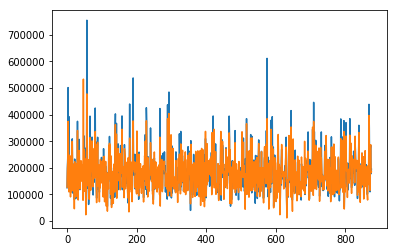

In [101]:
plt.plot(y_train)
plt.plot(predictions)
plt.show()

In [114]:
# Restore model and make predictions

with tf.Session(graph=graph) as sess:
    saver.restore(sess, "/tmp/linear-model.ckpt")
    print("Model restored.\nMaking predictions...")
    x = test_dataset.drop('Id', axis=1).as_matrix().astype(dtype=np.float32)
    test_dataset['SalePrice'] = tf.matmul(x, weights) + biases
    output = test_dataset[['Id', 'SalePrice']]

INFO:tensorflow:Restoring parameters from /tmp/linear-model.ckpt
Model restored.
Making predictions...


In [115]:
print(output.head())

         Id                                          SalePrice
0  0.000000  Tensor("add_4:0", shape=(1459, 1), dtype=float32)
1  0.000686  Tensor("add_4:0", shape=(1459, 1), dtype=float32)
2  0.001372  Tensor("add_4:0", shape=(1459, 1), dtype=float32)
3  0.002058  Tensor("add_4:0", shape=(1459, 1), dtype=float32)
4  0.002743  Tensor("add_4:0", shape=(1459, 1), dtype=float32)


## Training with Neural Networks and Regression